In [1]:
import pandas as pd
pd.__version__


'1.4.2'

In [2]:
import numpy as np
np.__version__

'1.21.5'

In [3]:
# %pip install catboost
import sklearn
sklearn.__version__

'1.0.2'

In [4]:
import matplotlib
matplotlib.__version__

'3.5.1'

In [5]:
# ! pip install prettytable

In [6]:
import pylab as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor

import pickle
import time
import random

from prettytable import PrettyTable

In [7]:
microclimate = pd.read_csv("../result/microclimate_cut_WITH_LIGHT_V2.csv")
soil = pd.read_csv("../result/soil_cut.csv")

### Анализ и предобработка данных

Пять признаков: концентрация CO2 (ppt), температура (°C), влажность воздуха (%), свет (blue, %), свет (white, %), свет (red, %)

переменная microclimate

In [8]:
microclimate.head()

,Время (час),Концентрация CO2 (ppt),Температура (°C),Влажность воздуха (%),"Свет (blue, %)","Свет (white, %)","Свет (red, %)"
0,0.002569,824.294648,18.721771,74.413899,0.0,0.0,0.0
1,0.010146,819.765307,18.709477,73.572382,0.0,0.0,0.0
2,0.017723,819.006237,18.726213,73.570151,0.0,0.0,0.0
3,0.025300,825.059458,18.706500,74.239905,0.0,0.0,0.0
4,0.032877,827.696900,18.806767,74.565687,0.0,0.0,0.0


In [9]:
def correction(x):
    if x < 15:
        x = 0
    elif x > 15 and x < 42.5:
        x = 30
    elif x > 42.5 and x < 62.5:
        x = 50
    elif x > 62.5 and x < 82.5:
        x = 70
    elif x > 82.5:
        x = 100
    return x

microclimate['Свет (blue, %)'] = microclimate['Свет (blue, %)'].apply(correction)
microclimate['Свет (white, %)'] = microclimate['Свет (white, %)'].apply(correction)
microclimate['Свет (red, %)'] = microclimate['Свет (red, %)'].apply(correction)

In [10]:
microclimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236742 entries, 0 to 236741
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Время (час)             236742 non-null  float64
 1   Концентрация CO2 (ppt)  236742 non-null  float64
 2   Температура (°C)        236742 non-null  float64
 3   Влажность воздуха (%)   236742 non-null  float64
 4   Свет (blue, %)          236742 non-null  int64  
 5   Свет (white, %)         236742 non-null  int64  
 6   Свет (red, %)           236742 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 12.6 MB


In [11]:
microclimate.describe()

,Время (час),Концентрация CO2 (ppt),Температура (°C),Влажность воздуха (%),"Свет (blue, %)","Свет (white, %)","Свет (red, %)"
count,236742.000000,236742.000000,236742.000000,236742.000000,236742.000000,236742.000000,236742.000000
mean,896.876076,839.988570,21.623106,54.993618,11.636845,35.364278,13.671676
std,517.813442,68.519576,1.778478,10.101997,14.618143,34.984670,22.278614
min,0.002569,381.397885,18.168020,30.823036,0.000000,0.000000,0.000000
25%,448.439323,801.668477,20.246011,46.881879,0.000000,0.000000,0.000000
50%,896.876076,839.881859,21.294835,54.162818,0.000000,70.000000,0.000000
75%,1345.312830,880.085509,22.695449,63.184642,30.000000,70.000000,50.000000
max,1793.749583,1236.079686,27.984084,83.681035,30.000000,70.000000,50.000000


Четыре целевые переменные: процент влажности почвы для 1, 2, 4 и 8 литров торфа

In [12]:
soil.head()

,Время (час),1л,2л,4л,8л
0,0.002569,-4.989119,-3.672894,-5.911863,-6.743605
1,0.010146,-4.986277,-3.849423,-5.909429,-6.741132
2,0.017723,-4.983435,-3.689895,-5.906995,-6.738659
3,0.025300,-4.980593,-3.852541,-5.904560,-6.736185
4,0.032877,-4.977751,-3.681410,-5.718384,-6.733712


In [13]:
soil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236742 entries, 0 to 236741
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Время (час)  236742 non-null  float64
 1   1л           236742 non-null  float64
 2   2л           236742 non-null  float64
 3   4л           236742 non-null  float64
 4   8л           236742 non-null  float64
dtypes: float64(5)
memory usage: 9.0 MB


Четыре целевые переменные: процент влажности почвы для 1, 2, 4 и 8 литров торфа

soil - переменная влажности

In [14]:
soil.describe()

,Время (час),1л,2л,4л,8л
count,236742.000000,236742.000000,236742.000000,236742.000000,236742.000000
mean,896.876076,66.400237,67.852809,69.052452,66.850561
std,517.813442,20.610623,20.668283,21.285000,20.679862
min,0.002569,-4.989119,-4.083342,-5.911863,-6.743605
25%,448.439323,62.859670,64.812774,62.588154,59.715718
50%,896.876076,71.924444,74.012449,73.983302,67.808963
75%,1345.312830,78.945478,80.688146,84.018449,84.080376
max,1793.749583,98.548742,97.678110,99.317980,101.677814


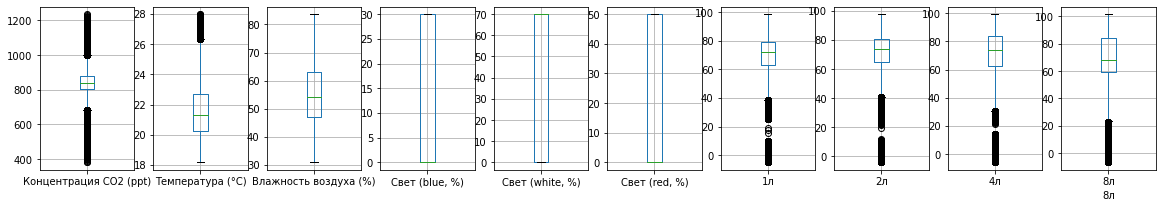

In [15]:
full_df = microclimate.drop(['Время (час)'], axis=1)
full_df['1л'] = soil['1л']
full_df['2л'] = soil['2л']
full_df['4л'] = soil['4л']
full_df['8л'] = soil['8л']

listvar = full_df.columns.tolist()
fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
counter=0
for ax in axes:
    full_df.boxplot(column=listvar[counter], ax=axes[counter])
    plt.xlabel(listvar[counter])
    counter += 1
plt.show()

Корреляции признаков друг с другом и с целевыми переменными

In [16]:
full_df1 = full_df.drop(['2л', '4л', '8л'], axis=1)
full_df2 = full_df.drop(['1л', '4л', '8л'], axis=1)
full_df4 = full_df.drop(['1л', '2л', '8л'], axis=1)
full_df8 = full_df.drop(['1л', '2л', '4л'], axis=1)

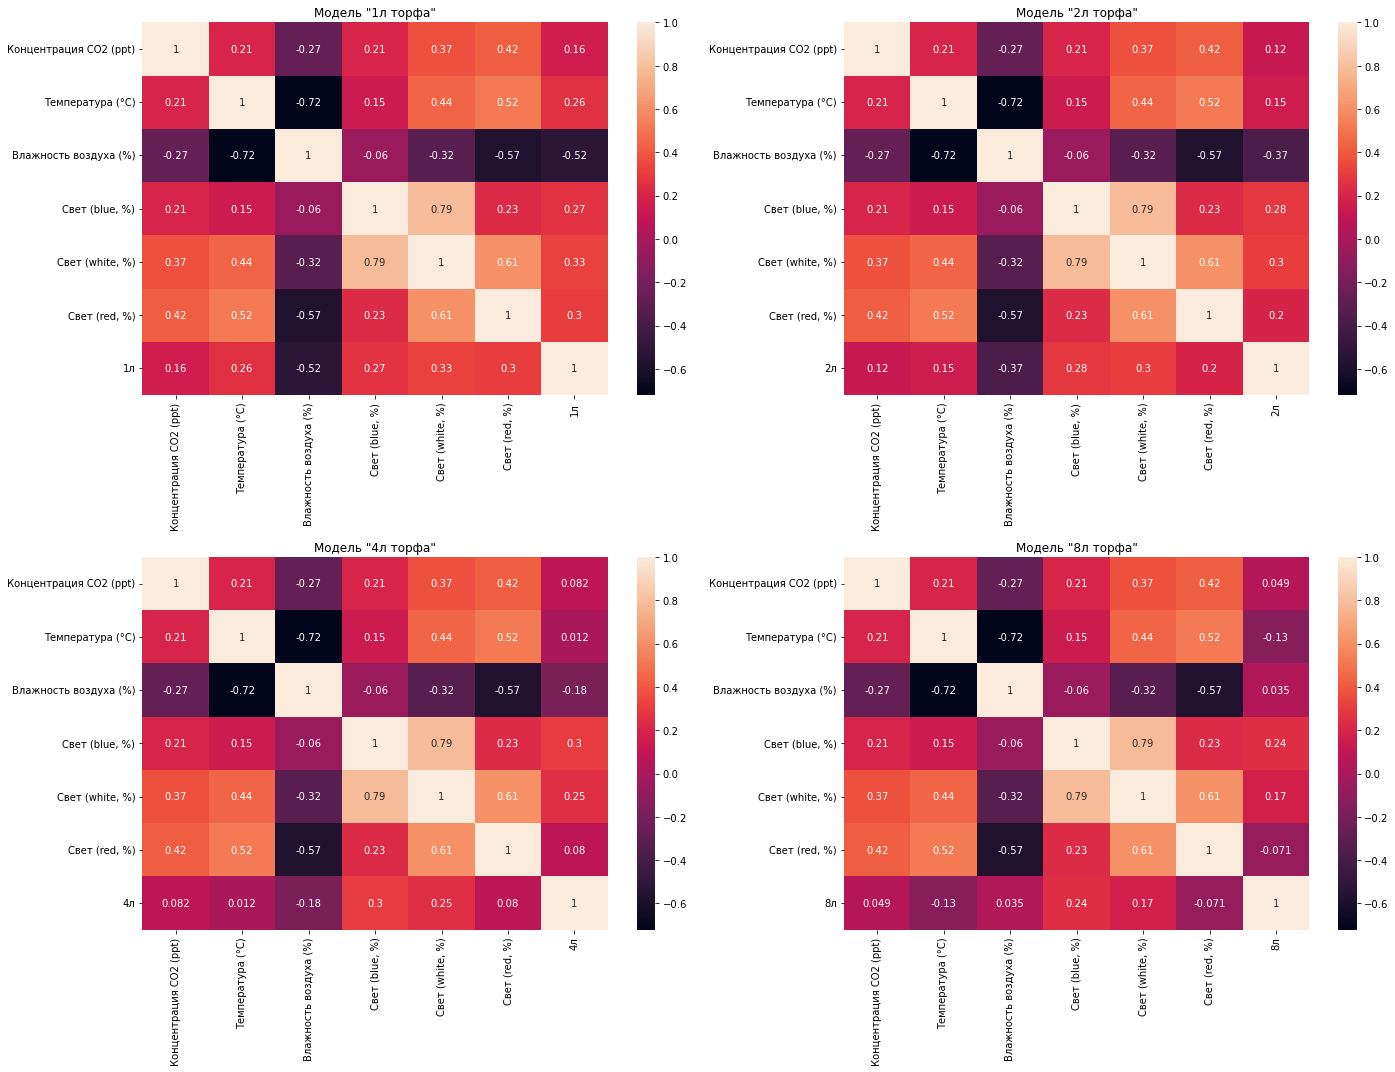

In [17]:
corr1 = full_df1.corr()
corr2 = full_df2.corr()
corr4 = full_df4.corr()
corr8 = full_df8.corr()

f, axs = plt.subplots(2, 2, figsize=(20,15))
g1 = sns.heatmap(corr1, annot=True,ax=axs[0,0]).set(title='Модель "1л торфа"')
g2 = sns.heatmap(corr2, annot=True,ax=axs[0,1]).set(title='Модель "2л торфа"')
g3 = sns.heatmap(corr4, annot=True,ax=axs[1,0]).set(title='Модель "4л торфа"')
g4 = sns.heatmap(corr8, annot=True,ax=axs[1,1]).set(title='Модель "8л торфа"')
f.tight_layout()

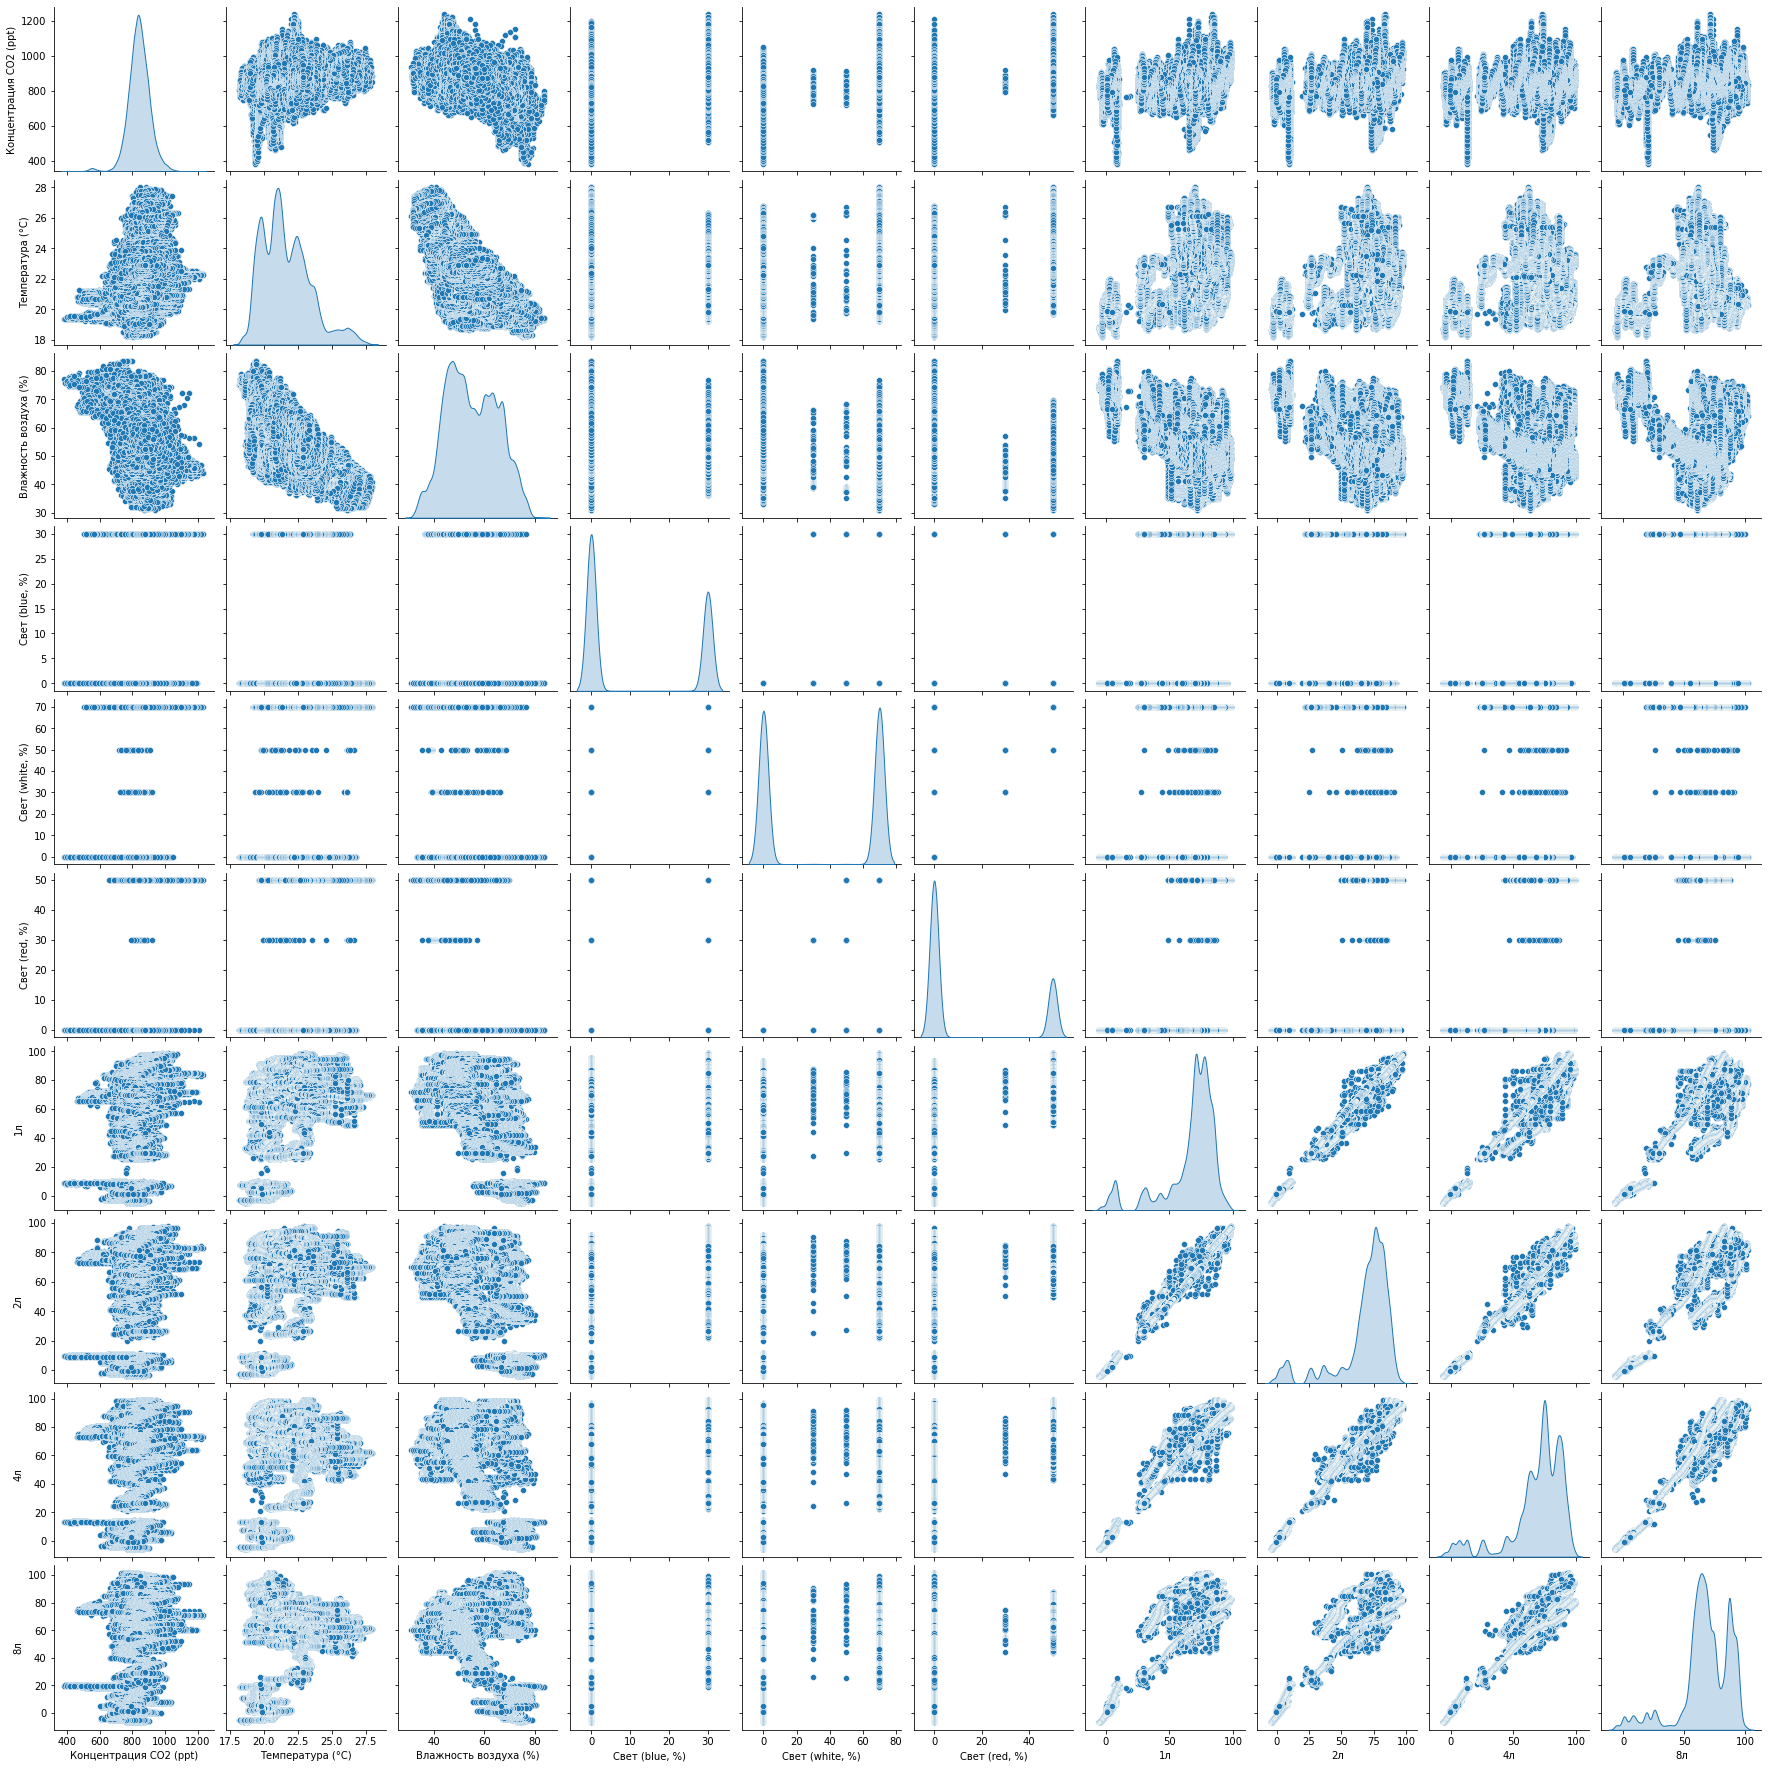

In [18]:
sns.pairplot(full_df[listvar], diag_kind='kde')

Применение StandardScaler 

In [19]:
TargetVariable=['1л', '2л', '4л', '8л']
Predictors=['Концентрация CO2 (ppt)', 'Температура (°C)', 'Влажность воздуха (%)', 
           'Свет (blue, %)', 'Свет (white, %)','Свет (red, %)']

X=full_df[Predictors].values
y=full_df[TargetVariable].values

pt = StandardScaler()
pt_ = pt.fit(X)
X = pt_.transform(X)
pickle.dump(pt_, open('models_v5/standard_scaler.pkl','wb'))

Разделение на обучающую и тестовую выборку

In [20]:
np.savetxt('models_v5/X.out', X)
np.savetxt('models_v5/y.out', y)

In [21]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, 
                                                  random_state = 123)

In [22]:
train_X_poly = train_X
val_X_poly = val_X

### Обучение моделей

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
import time 

def time_since(since):
    now = time.time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

- для 1 литра торфа

In [25]:
print("*** торф 1л ***")

start = time.time()
model_1 = RandomForestRegressor(n_jobs=2)
model_1.fit(train_X_poly,train_y[:, 0])

pickle.dump(model_1, open('models_v5/model_1.pkl','wb'))

predicted = model_1.predict(val_X_poly)
R2 = r2_score(val_y[:, 0], predicted)
print(f'\nR-squared = {R2:.3f}')
Adj_R2 = 1 - (1-R2)*(len(val_y[:, 0])-1)/(len(val_y[:, 0])-val_X_poly.shape[1]-1)
print(f'Adjusted R-squared = {Adj_R2:.3f}')

print(f'MAE = {mean_absolute_error(val_y[:, 0], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 0], predicted)}')
print(f'\ntime = {time_since(start)}')


*** торф 1л ***

R-squared = 0.820
Adjusted R-squared = 0.820
MAE = 4.671799513335434
MAPE = 0.47938948295321593

time = 1m 19s


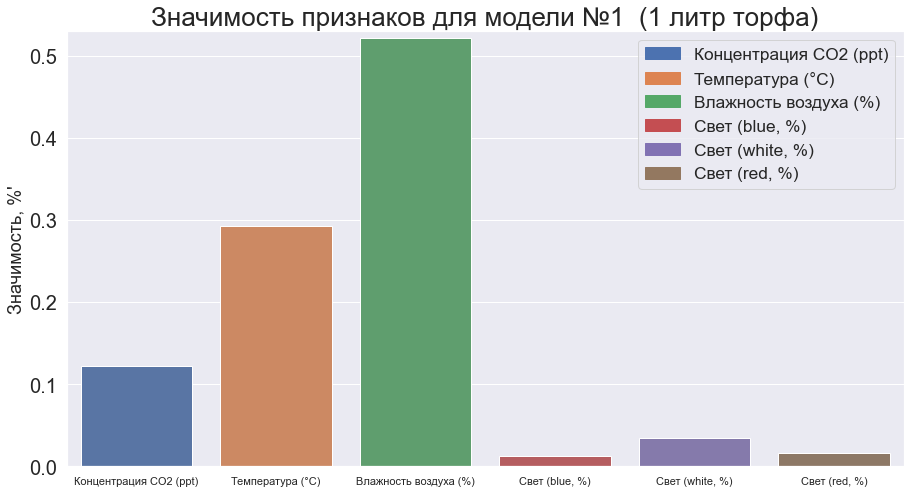

In [26]:
cat_imp = pd.DataFrame(model_1.feature_importances_, columns=['Значимость, %'], index=listvar[:6])
sns.set(rc={"figure.figsize":(15, 8)})
plot = sns.barplot(data=cat_imp.T)
plot.set(ylim=(0, 0.53))
plot.yaxis.set_tick_params(labelsize = 20)
plot.axes.set_title("Значимость признаков для модели №1  (1 литр торфа)",fontsize=26)
plot.axes.set_ylabel("Значимость, %'",fontsize=18)
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in plot.get_xticklabels())]
r = plt.legend(handles=patches, loc="upper right", fontsize="x-large") 

In [27]:
cat_imp

,"Значимость, %"
Концентрация CO2 (ppt),0.122731
Температура (°C),0.292607
Влажность воздуха (%),0.521716
"Свет (blue, %)",0.012838
"Свет (white, %)",0.034036
"Свет (red, %)",0.016072


- для 2 литров торфа

In [28]:
print("*** торф 2л ***")

start = time.time()
model_2 = RandomForestRegressor(n_jobs=2)
model_2.fit(train_X_poly,train_y[:, 1])

pickle.dump(model_2, open('models_v5/model_2.pkl','wb'))

predicted = model_2.predict(val_X_poly)
R2 = r2_score(val_y[:, 1], predicted)
print(f'\nR-squared = {R2:.3f}')
Adj_R2 = 1 - (1-R2)*(len(val_y[:, 1])-1)/(len(val_y[:, 1])-val_X_poly.shape[1]-1)
print(f'Adjusted R-squared = {Adj_R2:.3f}')

print(f'MAE = {mean_absolute_error(val_y[:, 1], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 1], predicted)}')
print(f'\ntime = {time_since(start)}')

*** торф 2л ***

R-squared = 0.788
Adjusted R-squared = 0.788
MAE = 4.895180536970326
MAPE = 0.5577620401528162

time = 1m 11s


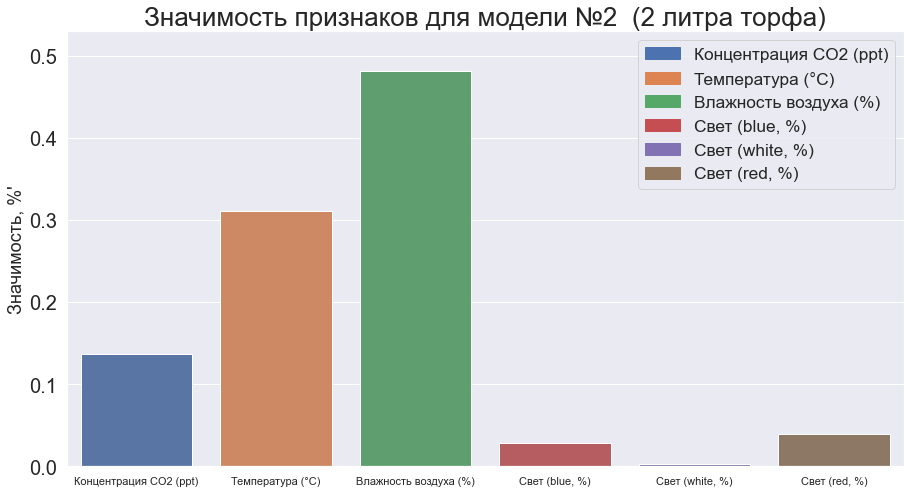

In [29]:
cat_imp = pd.DataFrame(model_2.feature_importances_, columns=['Значимость, %'], index=listvar[:6])
sns.set(rc={"figure.figsize":(15, 8)})
plot = sns.barplot(data=cat_imp.T)
plot.set(ylim=(0, 0.53))
plot.yaxis.set_tick_params(labelsize = 20)
plot.axes.set_title("Значимость признаков для модели №2  (2 литра торфа)",fontsize=26)
plot.axes.set_ylabel("Значимость, %'",fontsize=18)
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in plot.get_xticklabels())]
r = plt.legend(handles=patches, loc="upper right", fontsize="x-large") 

In [30]:
cat_imp

,"Значимость, %"
Концентрация CO2 (ppt),0.136648
Температура (°C),0.310876
Влажность воздуха (%),0.481741
"Свет (blue, %)",0.028379
"Свет (white, %)",0.003155
"Свет (red, %)",0.039201


- для 4 литров торфа

In [31]:
print("*** торф 4л ***")

start = time.time()
model_4 = RandomForestRegressor(n_jobs=2)
model_4.fit(train_X_poly,train_y[:, 2])

pickle.dump(model_4, open('models_v5/model_4.pkl','wb'))

predicted = model_4.predict(val_X_poly)
R2 = r2_score(val_y[:, 2], predicted)
print(f'\nR-squared = {R2:.3f}')
Adj_R2 = 1 - (1-R2)*(len(val_y[:, 2])-1)/(len(val_y[:, 2])-val_X_poly.shape[1]-1)
print(f'Adjusted R-squared = {Adj_R2:.3f}')

print(f'MAE = {mean_absolute_error(val_y[:, 2], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 2], predicted)}')
print(f'\ntime = {time_since(start)}')

*** торф 4л ***

R-squared = 0.771
Adjusted R-squared = 0.771
MAE = 5.18182714436252
MAPE = 0.8012150730947213

time = 1m 12s


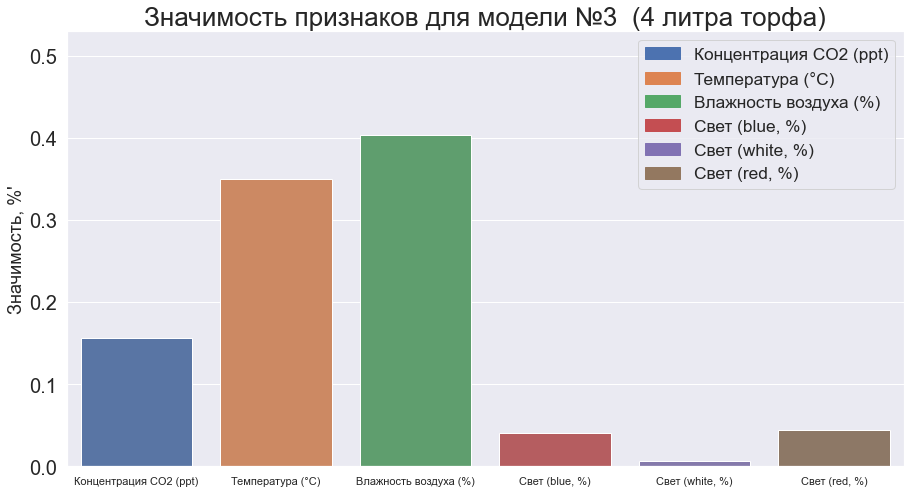

In [32]:
cat_imp = pd.DataFrame(model_4.feature_importances_, columns=['Значимость, %'], index=listvar[:6])
sns.set(rc={"figure.figsize":(15, 8)})
plot = sns.barplot(data=cat_imp.T)
plot.set(ylim=(0, 0.53))
plot.yaxis.set_tick_params(labelsize = 20)
plot.axes.set_title("Значимость признаков для модели №3  (4 литра торфа)",fontsize=26)
plot.axes.set_ylabel("Значимость, %'",fontsize=18)
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in plot.get_xticklabels())]
r = plt.legend(handles=patches, loc="upper right", fontsize="x-large") 

In [33]:
cat_imp

,"Значимость, %"
Концентрация CO2 (ppt),0.156007
Температура (°C),0.349911
Влажность воздуха (%),0.404143
"Свет (blue, %)",0.040103
"Свет (white, %)",0.005937
"Свет (red, %)",0.043897


- для 8 литров торфа

In [34]:
print("*** торф 8л ***")

start = time.time()
model_8 = RandomForestRegressor(n_jobs=2)
model_8.fit(train_X_poly,train_y[:, 3])

pickle.dump(model_8, open('models_v5/model_8.pkl','wb'))

predicted = model_8.predict(val_X_poly)
R2 = r2_score(val_y[:, 3], predicted)
print(f'\nR-squared = {R2:.3f}')
Adj_R2 = 1 - (1-R2)*(len(val_y[:, 3])-1)/(len(val_y[:, 3])-val_X_poly.shape[1]-1)
print(f'Adjusted R-squared = {Adj_R2:.3f}')

print(f'MAE = {mean_absolute_error(val_y[:, 3], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 3], predicted)}')
print(f'\ntime = {time_since(start)}')

*** торф 8л ***

R-squared = 0.749
Adjusted R-squared = 0.749
MAE = 4.855407127397268
MAPE = 1.708443175190642

time = 1m 13s


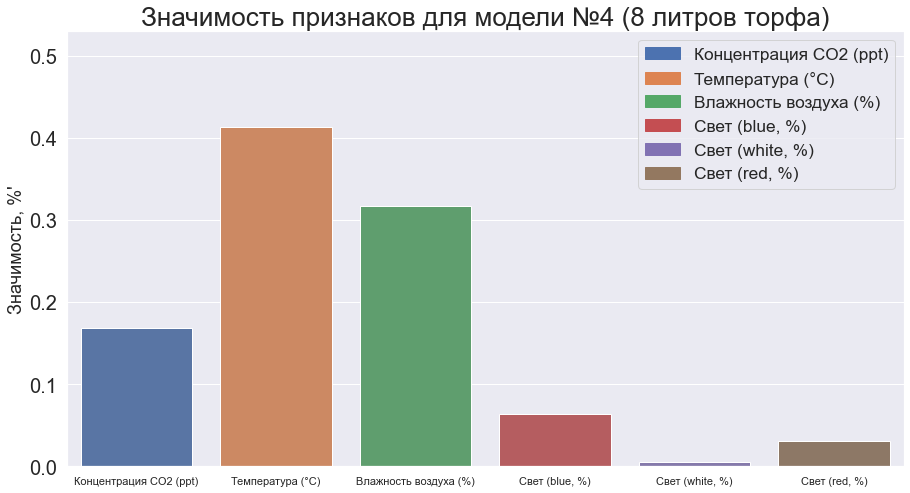

In [35]:
cat_imp = pd.DataFrame(model_8.feature_importances_, columns=['Значимость, %'], index=listvar[:6])
sns.set(rc={"figure.figsize":(15, 8)})
plot = sns.barplot(data=cat_imp.T)
plot.set(ylim=(0, 0.53))
plot.yaxis.set_tick_params(labelsize = 20)
plot.axes.set_title("Значимость признаков для модели №4 (8 литров торфа)",fontsize=26)
plot.axes.set_ylabel("Значимость, %'",fontsize=18)
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in plot.get_xticklabels())]
r = plt.legend(handles=patches, loc="upper right", fontsize="x-large") 

In [36]:
cat_imp

,"Значимость, %"
Концентрация CO2 (ppt),0.168644
Температура (°C),0.413279
Влажность воздуха (%),0.317466
"Свет (blue, %)",0.064029
"Свет (white, %)",0.005583
"Свет (red, %)",0.031000


#### Вывод результата

In [37]:
def result(n):
    predicted1 = model_1.predict([val_X_poly[n]])
    predicted2 = model_2.predict([val_X_poly[n]])
    predicted4 = model_4.predict([val_X_poly[n]])
    predicted8 = model_8.predict([val_X_poly[n]])
    x_ = pt_.inverse_transform([val_X[n]])
    pred_1 = predicted1[0]
    pred_2 = predicted2[0]
    pred_4 = predicted4[0]
    pred_8 = predicted8[0]
    true_y1 = val_y[n][0]
    true_y2 = val_y[n][1]
    true_y4 = val_y[n][2]
    true_y8 = val_y[n][3]
    table1, table2 = PrettyTable(), PrettyTable()
    table1.field_names = ["Концентрация CO2(ppt)", "Температура(°C)", "Влажность воздуха(%)", 
                         "Свет(blue, %)", "Свет(white, %)", "Свет(red, %)" ]
    table2.field_names = ["Модель", "Прогноз", "Реальные" ]

    table1.add_row([round(x_[0][i], 2) for i in range(6) ])
    table2.add_row(["1л", round(pred_1, 2), round(true_y1, 2)])
    table2.add_row(["2л", round(pred_2, 2), round(true_y2, 2)])
    table2.add_row(["4л", round(pred_4, 2), round(true_y4, 2)])
    table2.add_row(["8л", round(pred_8, 2), round(true_y8, 2)])
    print(table1)
    print(table2)

In [38]:
result(random.randint(0, val_X.shape[0]))

+-----------------------+-----------------+----------------------+---------------+----------------+--------------+
| Концентрация CO2(ppt) | Температура(°C) | Влажность воздуха(%) | Свет(blue, %) | Свет(white, %) | Свет(red, %) |
+-----------------------+-----------------+----------------------+---------------+----------------+--------------+
|         761.06        |      20.78      |        50.94         |      0.0      |      0.0       |     0.0      |
+-----------------------+-----------------+----------------------+---------------+----------------+--------------+
+--------+---------+----------+
| Модель | Прогноз | Реальные |
+--------+---------+----------+
|   1л   |   74.3  |  63.18   |
|   2л   |   70.5  |  63.41   |
|   4л   |   70.3  |  62.58   |
|   8л   |  58.92  |  51.11   |
+--------+---------+----------+


In [39]:
# from sklearn.model_selection import GridSearchCV

# grid = { 
#     'n_estimators': [10,50,100,500,1000],
#     'max_features': ['sqrt','log2', None],
#     'max_depth' : [3,7,15, None]
# }
# start = time.time()
# CV_rfr = GridSearchCV(estimator=RandomForestRegressor(n_jobs=3, verbose=100), 
#                       param_grid=grid, cv= 3)
# CV_rfr.fit(train_X, train_y)
# print(time_since(start))

In [40]:
# CV_rfr.best_estimator_